In [1]:
using CSV
using DataFrames
using Printf
using LinearAlgebra
using Statistics
using PyPlot
using PorousMaterials: fit_adsorption_isotherm, read_atomic_masses
using LaTeXStrings
using ProgressMeter
using HTTP
using JSON

## Lets start by loading in information from the NIST DB

In [2]:
host = "https://adsorption.nist.gov"

"https://adsorption.nist.gov"

### Gases:

In [3]:
url = host * "/isodb/api/gases.json"
r = HTTP.request("POST", url)
gas_data = JSON.parse(String(r.body))
key_to_gas = Dict{AbstractString, AbstractString}()
for gas in gas_data
    key_to_gas[gas["InChIKey"]] = gas["name"]
end

### Porous Materials

In [4]:
url = host * "/isodb/api/materials.json"
r = HTTP.request("POST", url)
material_data = JSON.parse(String(r.body))
key_to_material = Dict{AbstractString, AbstractString}()
for material in material_data
    key_to_material[material["hashkey"]] = material["name"]
end

In [5]:
master_list_of_gases = collect(values(key_to_gas));
master_list_of_materials = collect(values(key_to_material));

#### Plenty of materials/gases will be removed or merged due to:
* Not being experimental
* Not being within our temperature range (293K - 303K)
* Having incompatable units (we only accept units from the following list: [cm3(STP)/g, g/g, mg/g, ml/g, mmol/g, mmol/kg, mol/g, wt%]
* Having more than one adsorbate
* Not having enough unique isotherms (see further details below)
* Failure in fitting functions
* And more depending on validity and fitting functions

### Lets load in all of the isotherms we have in the `isotherms` directory. If that directory does not exist, we will download the data from the NIST DB and save it

In [6]:
isotherm_directory = "isotherms"
isotherm_dictionary = Dict{AbstractString, Dict{AbstractString, Array{AbstractString, 1}}}()

url = host * "/isodb/api/isotherms.json"
r = HTTP.request("POST", url)
isotherm_data = JSON.parse(String(r.body))

# This will download all isotherms from the NIST DB if the directory `isotherms` does not exist.
# In the Github repo we have provided both a zipped `isotherms` directory and a tarball containing the `isotherms` directory
if !isdir(joinpath(pwd(), isotherm_directory))
    @printf("Directory does not exist.\nStarting a long downloading process (roughly 3 hours)\n")
    mkdir(joinpath(pwd(), isotherm_directory))
    p = Progress(length(isotherm_data))
    for isotherm in isotherm_data
        url = host * "/isodb/api/isotherm/" * isotherm["filename"] * ".json"
        r = HTTP.request("POST", url)
        bibliography = JSON.parse(String(r.body))
        open(joinpath(pwd(), isotherm_directory, isotherm["filename"] * ".json"), "w") do file
            print(file, JSON.json(bibliography))
        end
        ProgressMeter.next!(p)
    end
end

for isotherm in isotherm_data
    gas = key_to_gas[isotherm["adsorbates"][1]["InChIKey"]]
    @assert gas in master_list_of_gases
    material = key_to_material[isotherm["adsorbent"]["hashkey"]]
    @assert material in master_list_of_materials
    
    if !haskey(isotherm_dictionary, gas)
        isotherm_dictionary[gas] = Dict{AbstractString, Array{AbstractString, 1}}()
    end
    if !haskey(isotherm_dictionary[gas], material)
        isotherm_dictionary[gas][material] = Array{AbstractString, 1}()
    end
    push!(isotherm_dictionary[gas][material], isotherm["filename"])
end

### Let's create fitting functions, validity functions and a few helper functions
The <i>validity functions</i> will make sure the isotherms have the valid units, are within valid temperature range etc.</br>
The <i>fitting functions</i> take in the isotherm filenames from the validity functions and compute the Henry coefficient of the isotherms, interpolate the adsorption at a specific pressure etc.</br>

## Helper functions

#### For the fitting procedures we need consistent units, so lets create a few helper functions that we'll use to convert the adsorption units to <b>mmol/g</b> (the pressure units are always <b>bar</b>)</br>
#### First we need to be able to compute the molecular weight of the adsorbates. To do that we'll read in the gas data and store the chemical formula of all gases. We'll also need the atomic weight of every element

In [7]:
gas_to_formula = Dict{AbstractString, AbstractString}()
for gas in master_list_of_gases
    url = host * "/isodb/api/gas/" * gas * ".json"
    url = replace(url, " " => "%20")
    r = HTTP.request("POST", url)
    gas_data = JSON.parse(String(r.body))
    gas_to_formula[gas] = gas_data["formula"]
end

atomic_masses = read_atomic_masses()

Dict{Symbol,Float64} with 100 entries:
  :Xe__    => 131.293
  :Cl      => 35.453
  :Al      => 26.9815
  :Be      => 9.01218
  :Re      => 186.207
  :O_RCOO  => 15.9994
  :Cr      => 51.996
  :Na      => 22.9898
  :N_in_N2 => 14.0067
  :VOID    => 0.0
  :Sb      => 121.76
  :Kr      => 83.798
  :Ni      => 58.6934
  :S       => 32.065
  :CH4     => 16.04
  :O_zeo   => 15.9994
  :Ru      => 101.07
  :Tm      => 168.934
  :C_sp3   => 12.0107
  :Xe_     => 131.293
  :Nd      => 144.242
  :O       => 15.9994
  :Tb      => 158.925
  :Th      => 232.038
  :Zr      => 91.224
  ⋮        => ⋮

In [8]:
function formula_to_mw(formula::AbstractString)
    start_i = 1
    elements = []
    for (end_i, letter) in enumerate(formula)
        if end_i == 1
            continue
        end
        if isuppercase(letter)
            push!(elements, [start_i, end_i-1])
            start_i = end_i
        end
    end
    push!(elements, [start_i, length(formula)])
    
    total_mw = 0
    for element in elements
        form = formula[element[1]:element[2]]
        contains_digits = any(isdigit(c) for c in form)
        if contains_digits
            for (i, letter) in enumerate(form)
                if isdigit(letter)
                    element_mw = atomic_masses[Symbol(form[1:i-1])]
                    total_mw += element_mw * parse(Int, form[i:end])
                    break
                end
            end
        else
            element_mw = atomic_masses[Symbol(form)]
            total_mw += element_mw
        end
    end
    return total_mw
end
formula_to_mw("CH3OH")

32.04186

In [9]:
function read_isotherm(isotherm_filename::AbstractString)
    isotherm = Dict{AbstractString, Any}()
    open("isotherms/" * isotherm_filename * ".json") do isotherm_file
        isotherm = JSON.parse(isotherm_file)
    end
    return isotherm
end
isotherm = read_isotherm("10.1002adem.200500223.isotherm1")

Dict{String,Any} with 15 entries:
  "isotherm_data"      => Any[Dict{String,Any}("pressure"=>0.0171192,"total_ads…
  "temperature"        => 77
  "articleSource"      => "UNKNOWN"
  "compositionType"    => "molefraction"
  "adsorbates"         => Any[Dict{String,Any}("name"=>"Hydrogen","InChIKey"=>"…
  "adsorptionUnits"    => "cm3(STP)/g"
  "date"               => "1000-01-01"
  "category"           => ""
  "digitizer"          => "UNKNOWN"
  "pressureUnits"      => "bar"
  "DOI"                => "10.1002/adem.200500223"
  "adsorbent"          => Dict{String,Any}("name"=>"CuBTC","hashkey"=>"NIST-MAT…
  "concentrationUnits" => ""
  "filename"           => "10.1002adem.200500223.isotherm1"
  "isotherm_type"      => ""

In [10]:
function convert_units(isotherm_data)
    
    aUnit = isotherm_data["adsorptionUnits"]
    @assert aUnit in ["cm3(STP)/g", "g/g", "mg/g", "ml/g", "mmol/g", "mmol/kg", "mol/g", "wt%"]
    
    aConversion = 0.0
    if aUnit == "mmol/g"
        aConversion = 1.0
    elseif aUnit == "mmol/kg"
        aConversion = 1.0 / 1000.0
    elseif aUnit == "mol/g"
        aConversion = 1000.0
    elseif aUnit == "wt%"
        gas = isotherm_data["adsorbates"][1]["name"]
        mw = formula_to_mw(gas_to_formula(gas))
        aConversion = 1000.0 / mw * 0.01
    elseif aUnit == "g/g"
        gas = isotherm_data["adsorbates"][1]["name"]
        mw = formula_to_mw(gas_to_formula(gas))
        aConversion = 1000.0 / mw
    elseif aUnit == "ml/g" || aUnit == "cm3(STP)/g"
        aConversion = 1.0 / 22.4
    elseif aUnit == "mg/g"
        gas = isotherm_data["adsorbates"][1]["name"]
        mw = formula_to_mw(gas_to_formula(gas))
        aConversion = 1.0 / mw
    else
        @error @sprintf("Something went wrong with the unit conversion in file %s", isotherm_filename)
    end
                                
    adsorption = Array{Float64, 1}()
    pressure = Array{Float64, 1}()
    for data_point in isotherm_data["isotherm_data"]
        push!(pressure, data_point["pressure"])
        push!(adsorption, data_point["species_data"][1]["adsorption"] * aConversion)
    end
    return pressure, adsorption
end
p, a = convert_units(isotherm)

([0.0171192, 0.0586318, 0.102329, 0.211573, 0.303338, 0.412581, 0.499976, 0.60485, 0.705355, 0.801489, 0.901993, 0.998128], [0.9231339285714286, 3.093375, 4.580848214285715, 6.4096875, 7.507008928571429, 8.409241071428571, 8.921339285714286, 9.506562500000001, 9.969866071428571, 10.311250000000001, 10.603883928571427, 10.823348214285716])

## Validity functions

In [11]:
function _check_nb_of_adsorbates(isotherm::Dict{<:AbstractString, Any}, max_adsorbates::Int=1)
    if length(isotherm["adsorbates"]) > max_adsorbates
        return false
    end
    return true
end

_check_nb_of_adsorbates (generic function with 2 methods)

In [12]:
function _check_temperature(isotherm::Dict{<:AbstractString, Any}, low_temp::Float64=293.0, high_temp::Float64=303.0)
    if isotherm["temperature"] >= low_temp && isotherm["temperature"] <= high_temp
        return true
    end
    return false
end     

_check_temperature (generic function with 3 methods)

In [13]:
function _check_units(isotherm::Dict{<:AbstractString, Any}, valid_units::Array{<:AbstractString, 1}=["cm3(STP)/g", "g/g", "mg/g", "ml/g", "mmol/g", "mmol/kg", "mol/g", "wt%"])
    if (isotherm["adsorptionUnits"] in valid_units) && isotherm["pressureUnits"] == "bar"
        return true
    end
    return false
end

_check_units (generic function with 2 methods)

In [14]:
function _check_category(isotherm::Dict{<:AbstractString, Any}, allow_uncategorized::Bool=true)
    if isotherm["category"] == "exp" || (isotherm["category"] == "" && allow_uncategorized)
        return true
    end
    return false
end

_check_category (generic function with 2 methods)

Lets load in an isotherm to test these functions:

In [15]:
test_isotherm = read_isotherm("10.1002adem.200500223.isotherm1")

Dict{String,Any} with 15 entries:
  "isotherm_data"      => Any[Dict{String,Any}("pressure"=>0.0171192,"total_ads…
  "temperature"        => 77
  "articleSource"      => "UNKNOWN"
  "compositionType"    => "molefraction"
  "adsorbates"         => Any[Dict{String,Any}("name"=>"Hydrogen","InChIKey"=>"…
  "adsorptionUnits"    => "cm3(STP)/g"
  "date"               => "1000-01-01"
  "category"           => ""
  "digitizer"          => "UNKNOWN"
  "pressureUnits"      => "bar"
  "DOI"                => "10.1002/adem.200500223"
  "adsorbent"          => Dict{String,Any}("name"=>"CuBTC","hashkey"=>"NIST-MAT…
  "concentrationUnits" => ""
  "filename"           => "10.1002adem.200500223.isotherm1"
  "isotherm_type"      => ""

In [29]:
@assert _check_category(test_isotherm)
@assert !_check_category(test_isotherm, false)
@assert _check_units(test_isotherm)
@assert !_check_temperature(test_isotherm)
@assert _check_temperature(test_isotherm, 0., 100.)
@assert _check_nb_of_adsorbates(test_isotherm)

## Fitting Functions

In [16]:
function _fit_henry_to_isotherm(isotherm::Dict{<:AbstractString, Any}, MSE_threshold::Float64=0.1)
    pressure, adsorption = convert_units(isotherm)
    isotherm_df = DataFrame(:p => pressure, :a => adsorption)
    params = fit_adsorption_isotherm(isotherm_df, :p, :a, :langmuir)
    H = params["M"] * params["K"]
    MSE = params["MSE"]
    if MSE >= MSE_threshold
        @error @sprintf("MSE of henry fit of file %s is too large", isotherm_filename)
    elseif params["M"] <= 0 || params["K"] <= 0
        @error @sprintf("Optimization of %s resulted in a negative Henry coefficient", isotherm_filename)
    end
    return H
end

_fit_henry_to_isotherm (generic function with 2 methods)

In [17]:
function _interpolate_isotherm(isotherm::Dict{<:AbstractString, Any}, interpolation_pressure::Float64=10.1)
    pressure, adsorption = convert_units(isotherm)
    if interpolation_pressure < minimum(pressure) || interpolation_pressure > maximum(pressure)
        @error @sprintf("Interpolation is not possible in file %s at %.3f bar", isotherm_filename, interpolation_pressure)
    end
    pressure_difference = pressure .- interpolation_pressure
    i_high = argmax(pressure_difference .>= 0)
    i_low = i_high - 1
    interpolated_adsorption = adsorption[i_low] + (adsorption[i_high] - adsorption[i_low]) / (pressure[i_high] - pressure[i_low]) * (interpolation_pressure - pressure[i_low])
    return interpolated_adsorption
end

_interpolate_isotherm (generic function with 2 methods)

Lets visualize the fits on the test isotherm we loaded previously:

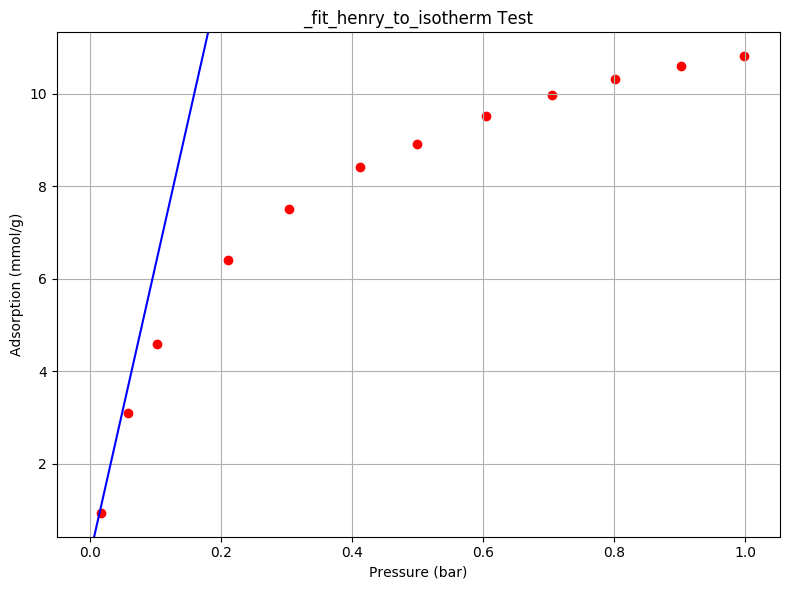

In [38]:
pressure, adsorption = convert_units(test_isotherm)
H = _fit_henry_to_isotherm(test_isotherm)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pressure, adsorption, c="red")
old_ylim = ax.get_ylim()
ax.plot([0, pressure[end]], [0, pressure[end]*H], c="blue")
ax.set_ylim(old_ylim)
ax.set_xlabel("Pressure (bar)")
ax.set_ylabel("Adsorption (mmol/g)")
ax.set_title("_fit_henry_to_isotherm Test")
ax.grid("on")
plt.tight_layout()
plt.show()

In [39]:
pressure, adsorption = convert_units(test_isotherm)
interpolated_adsorption = _interpolate_isotherm(test_isotherm)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pressure, adsorption, c="red")
old_ylim = ax.get_ylim()
ax.scatter(0.1, interpolated_adsorption, c="blue")
ax.set_ylim(old_ylim)
ax.set_xlabel("Pressure (bar)")
ax.set_ylabel("Adsorption (mmol/g)")
ax.set_title("_interpolate_isotherm Test")
ax.grid("on")
plt.tight_layout()
plt.show()

UndefVarError: UndefVarError: isotherm_filename not defined

### We'll also need a function to get rid of columns and/or rows that contain too few values

In [18]:
function prune(H::Array{Union{Float64, Missing}, 2}, min_unique_isotherms::Int=4)
    ng, nm = size(H)
    keep_col = trues(nm)
    keep_row = trues(ng)
    nb_kept_rows_and_cols = sum(keep_row) + sum(keep_col)
    nb_cut_cols = 0
    nb_cut_rows = 0
    count = 0
    
    while true
        for i_row = 1:ng
            if sum(.!ismissing.(H[i_row, keep_col])) < min_unique_isotherms
                keep_row[i_row] = false
            end
        end
        
        for i_col = 1:nm
            if sum(.!ismissing.(H[keep_row, i_col])) < min_unique_isotherms
                keep_col[i_col] = false
            end
        end
        
        if nb_kept_rows_and_cols == (sum(keep_row) + sum(keep_col))
            break
        end
        
        nb_kept_rows_and_cols = sum(keep_row) + sum(keep_col)
        count += 1
    end
    
    rows_cut = sum(.!keep_row)
    cols_cut  = sum(.!keep_col)
    
    @printf("Number of gases cut: %d\n", rows_cut)
    @printf("Number of materials cut: %d\n", cols_cut)
    @printf("Dimensions of H went from (%d, %d) to (%d, %d)\n", ng, nm, ng-rows_cut, nm-cols_cut)
    @printf("Number of iterations required to prune H: %d\n", count)
    
    return keep_row, keep_col
end

prune (generic function with 2 methods)

### Before we start filling <b>H</b>, lets merge some materials together that should be listed under the same material but aren't

In [19]:
# Return a new master_list_of_materials
# Also modifies the pre-existing `isotherm_dictionary`
function merge_materials(master_list_of_materials::Array{AbstractString, 1}, target::AbstractString, to_be_merged::Array{<:AbstractString, 1})
    # First we delete the MOFs that are to be merged from the master list of materials
    index_of_to_be_merged = [(mof in to_be_merged) for mof in master_list_of_materials]
    new_master_list_of_materials = master_list_of_materials[.!index_of_to_be_merged]

    # Then we combine the isotherms from the merged materials with the target material
    for gas_key in keys(isotherm_dictionary)
        for merging_material in to_be_merged
            if haskey(isotherm_dictionary[gas_key], merging_material)
                if !haskey(isotherm_dictionary[gas_key], target)
                    isotherm_dictionary[gas_key][target] = Array{AbstractString, 1}()
                end
                append!(isotherm_dictionary[gas_key][target], isotherm_dictionary[gas_key][merging_material])
            end
        end
    end
    return new_master_list_of_materials
end

merge_materials (generic function with 1 method)

In [20]:
new_master_list_of_materials = merge_materials(master_list_of_materials, "Mg-MOF-74", 
                                                            ["CPO-27-Mg", "CPO-27-Mg(100%)", "CPO-27-Mg-a", "CPO-27-Mg-b", "CPO-27-Mg-c", "Mg-MOF-74 (3)", 
                                                             "Mg-MOF-74 (4)", "MOF-74(Mg)-1st cycle", "Mg-MOF-74(C)", "Mg-MOF-74(C)-TEA", "Mg-MOF-74(S)",
                                                             "Mg-DOBDC", "Mg2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "CPO-27-Co",
                                                            ["Co-MOF-74(M)", "Co-MOF-74(S)", "Co-DOBDC", "Co2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "CPO-27-Ni",
                                                            ["Ni-MOF-74 (1)", "Ni-MOF-74 (2)", "MOF-74-Ni", "MOF-74Ni 70C", "Ni-DOBDC", "Ni2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Mn-MOF-74",
                                                            ["CPO-27-Mn", "Mn-DOBDC", "Mn2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Zn-MOF-74",
                                                            ["Zn-MOF-74(cycle 1)", "Zn-MOF-74(cycle 2)", "Zn-MOF-74(cycle 3)", "Zn-MOF-74(cycle 4)",
                                                             "Zn-MOF-74(cycle 5)", "CPO-27-Zn", "MOF-74", "MOF-74 (DMF)", "MOF-74 (water)",
                                                             "Zn-DOBDC", "Zn2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Cu-BDC",
                                                            ["Cu(BDC) (60mL DMF 100W Microwave)", "Cu(BDC) (60mL DMF 300W Microwave)",
                                                             "Cu(BDC) (87mL DMF 100W Microwave)", "Cu(BDC) (87mL DMF 300W Microwave)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "CuBTC",
                                                            ["Cu-BTC (diethylene glycol)", "Cu-BTC (ethylene glycol)", "Cu-HKUST-1", "CuBTC 100/100",
                                                             "CuBTC 50/110", "CuBTC 75/110", "CuBTC 75/140", "CuBTC 75/80", "Cu2(BTC)3", "CuBTC(Cu)",
                                                             "CuBTC-MW", "HKUST-1 (0T)", "HKUST-1 (1 pot)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Cu-SDU-1",
                                                            ["Cu-SDU-1 (100 degrees C)", "Cu-SDU-1 (40 degrees C)", "Cu-SDU-1 (80 degrees C)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Fe-MOF-74",
                                                            ["CPO-27-Fe", "Fe2(dobdc)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "IRMOF-1",
                                                            ["MOF-5 (1.5 hours activated)", "MOF-5 (Na2BDC 298)", "MOF-5 (Na2BDC 373)", "MOF-5-.5h in humid air",
                                                             "MOF-5-24h in humid air", "MOF-5-2h in humid air", "MOF-5-48h in humid air", "MOF-5-40h", 
                                                             "MOF-5-61% humidity", "MOF-5-61% humidity-exposedtoair.5h", "MOF-5-61% humidity-exposedtoair24h",
                                                             "MOF-5-61% humidity-exposedtoair2h", "MOF-5-61% humidity-exposedtoair48h", "MOF-5-BPO",
                                                             "MOF-5-BPO (cBPO = .04 M)", "MOF-5-BPO (cBPO = .06 M)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Ni(bodc)(ted)0.5",
                                                            ["Ni-bodc-ted"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "Ni(bdc)(ted)0.5",
                                                            ["Ni(bdc)(ted)0.5 t=100", "Ni(bdc)(ted)0.5 t=15"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "PCN-14",
                                                            ["PCN-14(440)", "PCN-14(450)", "PCN-14(500)", "PCN-14(550)", "PCN-14(600)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "UiO-66",
                                                            ["UiO-66 (24h)", "UiO-66 (2h)", "UiO-66 (48h)", "UiO-66 (4h)", "UiO-66 (72h)",
                                                             "UiO-66 (8h)", "UiO-66 (solvothermal)", "UiO-66(Zr)", "UiO-66(Zr) 100 Equ. FA",
                                                             "UiO-66(Zr) 30 Equ. AA"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "UiO-66-NH2",
                                                            ["UiO-66-NH2(100)", "UiO-66-NH2(67)", "UiO-66-NH2(33)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "UiO-66-(COOH)2",
                                                            ["UiO-66(Zr)-(COOH)2", "UiO-66(Zr)-(COOH)2 (303K)", "UiO-66(Zr)-(COOH)2 (323K)", 
                                                             "UiO-66(Zr)-(COOH)2 (343K)", "UiO-66(Zr)-(COOH)2 (348K)", "UiO-66(Zr)-(COOH)2 (373K)",
                                                             "UiO-66(Zr)-(COOH)2 (383K)", "UiO-66(Zr)-(COOH)2 (423K)", "UiO-66(Zr)-(COOH)2 (463K)", 
                                                             "UiO-66(Zr)-(COOH)2 (473K)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "SNU-9",
                                                            ["SNU-9 (10 cycles)", "SNU-9 (100 cycles)"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "ZIF-8",
                                                            ["ZIF-8 (BULK)", "ZIF-8 (crystal = 0.060 micrometers)", "ZIF-8 (crystal = 0.33 micrometers)", 
                                                             "ZIF-8 (crystal = 0.47 micrometers)", "ZIF-8 (crystal = 0.73 micrometers)", 
                                                             "ZIF-8 (crystal = 1.2 micrometers)", "ZIF-8 (crystal = 2.1 micrometers)",
                                                             "ZIF-8 (crystal = 88 micrometers)", "ZIF-8 (Large Size)", "ZIF-8 (Middle Size)", "ZIF-8 (Small Size)",
                                                             "ZIF-8-0.025 WT% CTAB", "ZIF-8-C_100_2d", "ZIF-8-C_200_2d", "ZIF-8-C_250_2d", "ZIF-8-C_250_2d_V",
                                                             "ZIF-8-M_100_7d", "ZIF-8-M_200_2d", "ZIF-8-M_250_2d", "ZIF-8-M_250_2d_V", "ZIF-8-W_100_7d",
                                                             "ZIF-8-W_200_2d", "ZIF-8-W_250_2d", "ZIF-8-W_250_2d_V", "ZIF-8ER", "ZIF-8HP", "ZIF-8HT",
                                                             "ZIF-8LT", "ZIF-8LT-HT"])
new_master_list_of_materials = merge_materials(new_master_list_of_materials, "MCM-41",
                                                            ["2650 K MCM-41", "300 K MCM-41", "MCM-41 d=2.8 nm", "MCM-41 d=3.1 nm",
                                                             "MCM-41 1000C", "MCM-41 500C", "MCM-41 700C", "MCM-41 900C"])
master_list_of_materials = merge_materials(new_master_list_of_materials, "Cu-MOF-74",
                                                            ["Cu-DOBDC (DREIDING Parameters-Universal Force Field + TraPPe Model)", 
                                                             "CPO-27-Cu", "Cu2(dobdc)"])

6864-element Array{AbstractString,1}:
 "Mg2(dobpdc)"                               
 "Li-FAU(1.0)"                               
 "Soc-MOF"                                   
 "MIL-140C-25"                               
 "MOF-GO PSN"                                
 "1% Pt/BAl 1.0"                             
 "NENU-11"                                   
 "AMSA-MIL-101"                              
 "{[Co(dpt24)2)]*0.5DMF}n"                   
 "HFCP-17"                                   
 "MTV-IRMOF-1-AE"                            
 "36 wt% CuCl/NaX"                           
 "Coal RU1"                                  
 ⋮                                           
 "HB-d"                                      
 "Graphite (2-nm pore width)"                
 "Hydrated Graphite (20 Angstrom pore width)"
 "Gd2(ADB)3(DMSO)4*6DMSO*8H2O"               
 "[Cd2(Me4bpz)4{SiF6}{NCS}2]*6CHCl3"         
 "{[Cu2(pzdc)2(bpy)]*4H2O}"                  
 "Tb3+@Al-MIL-53-COOH"                    

### Lets initialize our data matrix <b>H</b>

In [21]:
nm = length(master_list_of_materials)
ng = length(master_list_of_gases)
@printf("Number of materials: %d\nNumber of gases: %d\n", nm, ng)
H = Array{Union{Float64, Missing}, 2}(undef, ng, nm)

Number of materials: 6864
Number of gases: 356


356×6864 Array{Union{Missing, Float64},2}:
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing 

## Lets create the function that fills in <b>H</b>

In [22]:
function fill_H!(H::Array{Union{Float64, Missing}, 2}, validity_functions::Array{<:Function, 1}, fit_function::Function, post_functions::Array{<:Function, 1})
    for (i, gas) in enumerate(master_list_of_gases)
        if !haskey(isotherm_dictionary, gas)
            continue
        end
        for (j, material) in enumerate(master_list_of_materials)
            if !haskey(isotherm_dictionary[gas], material)
                continue
            end
            isotherm_list = isotherm_dictionary[gas][material]
            isotherms = read_isotherm.(isotherm_list)
            ### Lets run the validity functions to see which isotherm files are valid
            valid_isotherms = trues(length(isotherm_list))
            for val_func in validity_functions
                valid_isotherms .= valid_isotherms .& val_func.(isotherms)
            end
            
            ### Lets run the fitting function now
            fit_vals = Array{Any, 1}(undef, length(isotherm_list))
            for (k, isotherm) in enumerate(isotherms)
                try
                    fit_vals[k] = fit_function(isotherm)
                catch
                    valid_isotherms[k] = false
                end
            end
            
            if sum(valid_isotherms) == 0
                continue
            end
                
            # Lets take the median of the fitted values to try to remove the effects of outlieres
            H[i,j] = median(fit_vals[valid_isotherms])
                
            ### And finally lets run the post processing functions
            for post_func in post_functions
                H[i,j] = post_func(H[i,j])
            end
        end
    end
    @printf("Sparsity before pruning: %.2f%%\n", sum(ismissing.(H))/length(H)*100)

    keep_row, keep_col = prune(H)
    H = H[keep_row, keep_col]

    @printf("Sparsity after pruning: %.2f%%\n", sum(ismissing.(H))/length(H)*100)
    return H, keep_row, keep_col
end
                    
new_H, keep_row, keep_col = fill_H!(H, [_check_nb_of_adsorbates, _check_temperature, _check_units, _check_category], _fit_henry_to_isotherm, [log10])
master_list_of_gases = master_list_of_gases[keep_row];
master_list_of_materials = master_list_of_materials[keep_col];

Sparsity before pruning: 99.87%
Number of gases cut: 326
Number of materials cut: 6726
Dimensions of H went from (356, 6864) to (30, 138)
Number of iterations required to prune H: 3
Sparsity after pruning: 81.84%


In [23]:
master_list_of_gases

30-element Array{AbstractString,1}:
 "Xenon"              
 "Benzene"            
 "Carbon monoxide"    
 "2-Propanol"         
 "Ethane"             
 "Argon"              
 "Oxygen"             
 "Carbon Dioxide"     
 "Krypton"            
 "Acetylene"          
 "Water"              
 "1-butene"           
 "Methanol"           
 ⋮                    
 "Methane"            
 "N-Butane"           
 "2-Methylbutane"     
 "N-propane"          
 "Sulfur Hexafluoride"
 "Ethanol"            
 "Helium"             
 "Hydrogen"           
 "Toluene"            
 "Sulfur dioxide"     
 "Nitrogen"           
 "Ethene"             